## MDS implementation

In [313]:
import pandas as pd
import numpy as np

In [314]:
class MDS:
    
    def __init__(self, n_components=2, metric='classic', n_init=4, max_iter=300, eps=0.001,alpha=0.005, random_state=None, dissimilarity='euclidean'):
        
        """
        Parameters:
        n_components-Number of dimensions in which to immerse the dissimilarities.
        metric-If True, perform metric MDS; otherwise, perform nonmetric MDS.
        n_init-Number of times the SMACOF algorithm will be run with different initializations. The final results will be the best output of the runs, determined by the run with the smallest final stress.
        max_iter-Maximum number of iterations of the SMACOF algorithm for a single run.
        eps-Relative tolerance with respect to stress at which to declare convergence.
        alpha-learning rate in nMDS 
        random_state-Determines the random number generator used to initialize the centers. 
        dissimilarity{‘euclidean’, ‘precomputed’}, default=’euclidean’-Dissimilarity measure.
        
        """
        self.n_components=n_components
        self.metric=metric
        self.n_init=n_init
        self.max_iter=max_iter
        self.eps=eps
        self.alpha=alpha
        self.random_state=random_state
        self.dissimilarity=dissimilarity
        
        
        """
        Attributes:
        embedding_-Stores the position of the dataset in the embedding space.
        stress_-The final value of the stress (sum of squared distance of the disparities and the distances for all constrained points).
        dissimilarity_matrix_-Pairwise dissimilarities between the points. Symmetric matrix that:constructs a dissimilarity matrix from data using Euclidean distances.
        n_iter_-The number of iterations corresponding to the best stress.
        
        """
       
    def gradient(self,B,V,Z):
            return 2*V@Z-2*B@Z
    
    def fit_transform(self,X):   
        
        import numpy as np
        n_samples_=len(X)
        self.embedding_=np.ndarray(shape=(n_samples_, self.n_components))
        self.stress_=100000000
        self.dissimilarity_matrix_=np.ndarray(shape=(n_samples_,n_samples_))
        self.n_iter_=None
        
        np.random.RandomState(self.random_state)
        
        from sklearn.metrics.pairwise import euclidean_distances
        if self.dissimilarity=='euclidean':
            self.dissimilarity_matrix_=euclidean_distances(X)
            D=self.dissimilarity_matrix_
        elif self.dissimilarity=='precomuted':
            self.dissimilarity_matrix_ = X
            D=X
        else: raise Exception("Unsupported parameter")
        Z=0
        
        if self.metric=='classic':

            C=np.eye(n_samples_)-1/n_samples_*np.ones(shape=(n_samples_,n_samples_))
            B=np.round(1/2*C@np.linalg.matrix_power(D, 2)@C,3)
            e_values, e_vectors = np.linalg.eig(B)
            indices = np.argsort(e_values)
            indices = indices[::-1]
            e_vectors = e_vectors[:,indices]
            e_values = e_values[indices]
            e_vectors = e_vectors[:,:self.n_components]
            Y=np.zeros((len(e_vectors[0]), len(e_vectors[0])))
            np.fill_diagonal(Y, np.sqrt(e_values))
            Z= e_vectors@Y
            New_D=euclidean_distances(Z)
            tmp_stress1=0
            tmp_stress2=0
            for i in range( n_samples_):
                for j in range(n_samples_):
                    tmp_stress1+=np.square(B[i][j]-X[i].T@X[j])
                    tmp_stress2+=np.square(B[i][j])        
            self.stress_=np.sqrt(tmp_stress1/tmp_stress2)
             
            self.embedding_=Z    
            
            return self.embedding_
            
            
        elif self.metric=='mMDS':#non Metric MDS algorithm
            
            list_of_Z=list()
            list_of_stress=list()
            list_of_n_iters=list()
            flag = False
            if self.random_state!=None:
                self.n_init=1
            for j in range(self.n_init):
                
                Z = np.random.random(n_samples_ * self.n_components)
                Z = Z.reshape((n_samples_, self.n_components))
               
                for i in range(self.max_iter):
                    D=euclidean_distances(Z)
                    B=np.zeros_like(D)
                    for k in range(D.shape[0]):
                        for l in range(D.shape[1]):
                            if k!=l and D[k][l]!=0:
                                B[k][l]=-self.dissimilarity_matrix_[k][l]/D[k][l]
                            elif k!=l and D[k][l]==0:
                                B[k][l]=0
                        lst=list()        
                    for k in range(B.shape[0]):
                        lst.append(-np.sum(B[k]))
                    np.fill_diagonal(B,lst)   
                    V=-1*np.ones_like(D)
                    np.fill_diagonal(V,n_samples_-1)
                    Z-=self.alpha*self.gradient(B,V,Z)   
                    tmp_stress=0
                    for k in range(D.shape[0]):
                        for l in range(D.shape[1]):
                            tmp_stress+=np.square(self.dissimilarity_matrix_[k][l]-D[k][l])
                    tmp_stress=np.sqrt(tmp_stress)       
                    if self.stress_-tmp_stress<=self.eps:
                        self.embedding_=Z
                        list_of_n_iters.append(self.n_iter_)
                        list_of_stress.append(self.stress_)
                        list_of_Z.append(Z)
                        self.embedding_=Z  
                        flag=True
                        break

                    if self.stress_>tmp_stress:
                        self.stress_=tmp_stress
                        self.n_iter_=i
                if not flag:        
                    list_of_n_iters.append(self.n_iter_)
                    list_of_stress.append(self.stress_)
                    list_of_Z.append(Z)
                    self.embedding_=Z  
                    
            index=np.argmin(list_of_stress)
            self.embedding_=list_of_Z[index]
            self.stress_=list_of_stress[index]
            self.n_iter_=list_of_n_iters[index]
        
            return self.embedding_
        
        elif self.metric=='nMDS':
            pass
        
        else:
            raise Exception("Unsupported parameter")
                    

In [315]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names = ['sepal length','sepal width','petal length','petal width','target'])

In [316]:
from sklearn.preprocessing import StandardScaler
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['target']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [332]:
mds = MDS(n_components=2,metric='mMDS')
mds_components= mds.fit_transform(x)

mdsDf = pd.DataFrame(data = mds_components, columns = ['component 1', 'component 2'])

In [333]:
mdsDf

,component 1,component 2
0,-1.373908,-0.872068
1,-1.678374,0.289156
2,-1.800874,-0.153507
3,-1.854453,0.118838
4,-1.426072,-1.074353
...,...,...
145,2.426322,0.854692
146,1.583157,1.998065
147,2.028538,0.860440
148,2.279598,-0.208761


In [334]:
finalDf = pd.concat([mdsDf, df[['target']]], axis = 1)

In [335]:
mds_components

array([[-1.37390838, -0.87206784],
       [-1.67837354,  0.28915646],
       [-1.80087388, -0.15350678],
       [-1.85445335,  0.11883812],
       [-1.42607246, -1.07435265],
       [-0.78572479, -1.72417433],
       [-1.75857045, -0.54396058],
       [-1.44851152, -0.61700918],
       [-2.09092406,  0.58870368],
       [-1.68879453,  0.05434769],
       [-1.04514468, -1.36231524],
       [-1.5872314 , -0.56701081],
       [-1.82675541,  0.28299759],
       [-2.30626735,  0.32312282],
       [-0.71984871, -2.17152546],
       [-0.47456964, -2.89980362],
       [-0.90750259, -1.78208868],
       [-1.30449711, -0.84633149],
       [-0.63225542, -1.60791933],
       [-1.18514474, -1.50754324],
       [-1.06630287, -0.68078687],
       [-1.14403784, -1.26096397],
       [-1.88252406, -1.06546464],
       [-1.12104375, -0.31613366],
       [-1.50850267, -0.5229917 ],
       [-1.54257598,  0.29983794],
       [-1.27446194, -0.54879154],
       [-1.2635721 , -0.88239774],
       [-1.3218689 ,

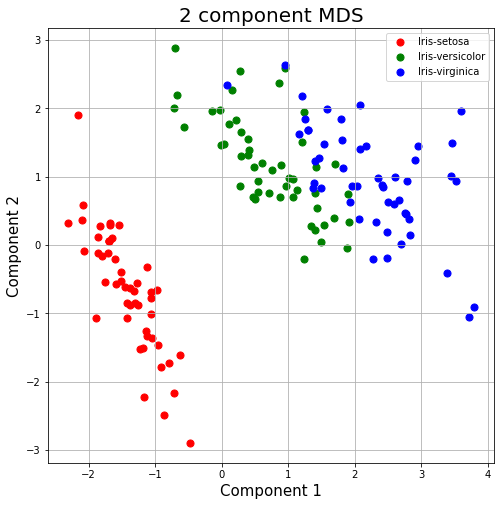

In [336]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('2 component MDS', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'component 1']
               , finalDf.loc[indicesToKeep, 'component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [337]:
mds.stress_

21.682092086390377

In [338]:
mds.embedding_

array([[-1.37390838, -0.87206784],
       [-1.67837354,  0.28915646],
       [-1.80087388, -0.15350678],
       [-1.85445335,  0.11883812],
       [-1.42607246, -1.07435265],
       [-0.78572479, -1.72417433],
       [-1.75857045, -0.54396058],
       [-1.44851152, -0.61700918],
       [-2.09092406,  0.58870368],
       [-1.68879453,  0.05434769],
       [-1.04514468, -1.36231524],
       [-1.5872314 , -0.56701081],
       [-1.82675541,  0.28299759],
       [-2.30626735,  0.32312282],
       [-0.71984871, -2.17152546],
       [-0.47456964, -2.89980362],
       [-0.90750259, -1.78208868],
       [-1.30449711, -0.84633149],
       [-0.63225542, -1.60791933],
       [-1.18514474, -1.50754324],
       [-1.06630287, -0.68078687],
       [-1.14403784, -1.26096397],
       [-1.88252406, -1.06546464],
       [-1.12104375, -0.31613366],
       [-1.50850267, -0.5229917 ],
       [-1.54257598,  0.29983794],
       [-1.27446194, -0.54879154],
       [-1.2635721 , -0.88239774],
       [-1.3218689 ,

In [339]:
mds.n_init

4